# 1. Import Needed Library

In [238]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tiktoken
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# 2. Read And Preprocessing Data

## 2.1 Read Data

In [241]:
# Read and convert data from the .txt file to dataframe

def read_sentiment_data(file_path):
    sentences = []
    sentiments = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:  # Skip empty lines
                # Split by the first semicolon
                parts = line.split(';', 1)
                if len(parts) == 2:
                    sentence, sentiment = parts
                    sentences.append(sentence)
                    sentiments.append(sentiment)
    
    # Create a dataframe
    df = pd.DataFrame({
        'sentence': sentences,
        'sentiment': sentiments
    })
    
    return df

file_path = 'Dataset/Raw dataset/emotions.txt'
df = read_sentiment_data(file_path)
df.head()

,sentence,sentiment
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


## 2.2 Exploratory Data Analysis (EDA)

### Explore Sentiment Distribution

In [244]:
print("Sentiment labels of the dataset:", list(df['sentiment'].unique()))

Sentiment labels of the dataset: ['fear', 'sadness', 'love', 'joy', 'surprise', 'anger']


In [245]:
# Display basic statistics
print(f"Total records: {len(df)}")
print(f"Sentiment distribution:\n{df['sentiment'].value_counts()}")

Total records: 416123
Sentiment distribution:
sentiment
joy         140779
sadness     120989
anger        57235
fear         47664
love         34497
surprise     14959
Name: count, dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

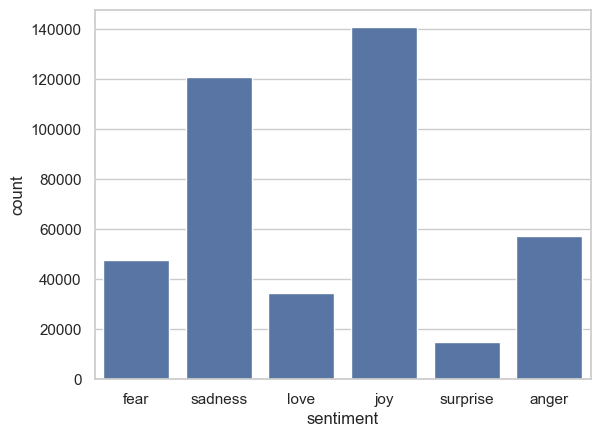

In [246]:
sns.countplot(x="sentiment", data=df)

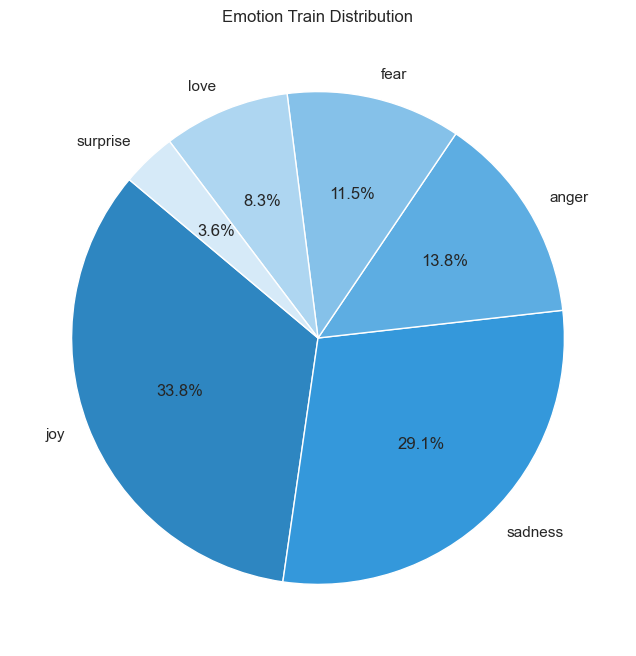

In [247]:
# Count label distributions
label_counts = df['sentiment'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
colors = ['#2E86C1', '#3498DB', '#5DADE2', '#85C1E9', '#AED6F1', '#D6EAF8']
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Emotion Train Distribution')
plt.show()

Since we have an unbalanced dataset, we can reduce the label of joy and sadness to be near the average to make the dataset balanced

In [249]:
def downsample_sentiments(df, sentiment_limits):
    # Create a copy to avoid modifying the original DataFrame
    downsampled_dfs = []
    
    for sentiment, limit in sentiment_limits.items():
        # Filter the DataFrame for the specific sentiment
        sentiment_df = df[df['sentiment'] == sentiment]
        
        # If the number of records exceeds the limit, randomly sample
        if len(sentiment_df) > limit:
            downsampled_sentiment = sentiment_df.sample(n=limit, random_state=42)
        else:
            downsampled_sentiment = sentiment_df
        
        downsampled_dfs.append(downsampled_sentiment)
    
    # Keep other sentiments unchanged
    other_sentiments = df[~df['sentiment'].isin(sentiment_limits.keys())]
    
    # Combine all DataFrames
    final_df = pd.concat([*downsampled_dfs, other_sentiments], ignore_index=True)
    
    return final_df

sentiment_limits = {
    'joy': 60000,
    'sadness': 55000
}

# Apply downsampling
df = downsample_sentiments(df, sentiment_limits)

# Verify the new distribution
print(df['sentiment'].value_counts())

sentiment
joy         60000
anger       57235
sadness     55000
fear        47664
love        34497
surprise    14959
Name: count, dtype: int64


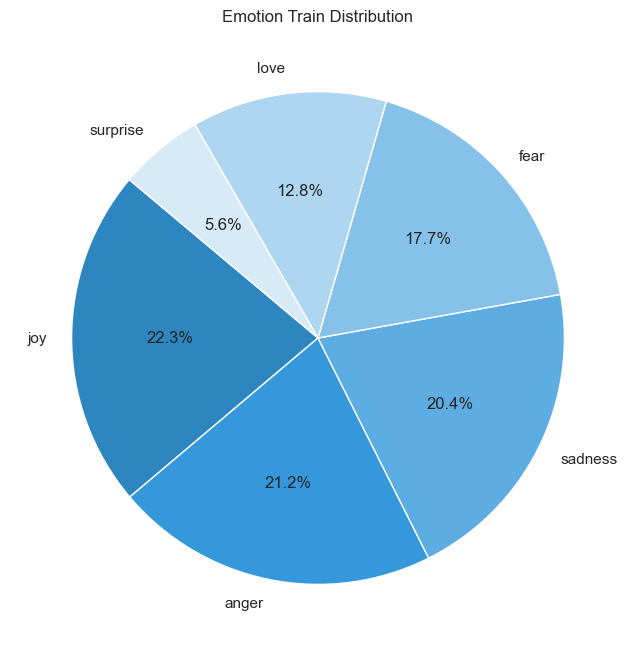

In [250]:
# Count label distributions
label_counts = df['sentiment'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
colors = ['#2E86C1', '#3498DB', '#5DADE2', '#85C1E9', '#AED6F1', '#D6EAF8']
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Emotion Train Distribution')
plt.show()

### Explore relationship between sentence length and sentiment labels

In [252]:
def word_count(sentence):
    sentence_list = sentence.split()
    return len(sentence_list)

df['length'] = df['sentence'].str.len()
df['word_count'] = df['sentence'].apply(word_count)
df['mean_word_length'] = df['sentence'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

In [253]:
df.head(10)

,sentence,sentiment,length,word_count,mean_word_length
0,i enjoyed feeling a little cool summer shower ...,joy,80,15,4.400000
1,i feel very positive he added,joy,29,6,4.000000
2,i hope a question comes up at the pub quiz won...,joy,66,14,3.785714
3,i have overwhelming feelings of just being a h...,joy,134,25,4.400000
4,i feel as though ive become almost too complac...,joy,176,31,4.709677
5,i feel that my parents instilled in me the val...,joy,237,55,3.327273
6,i had fun wearing this and it made me feel goo...,joy,60,13,3.692308
7,i can t remember what exactly i was referring ...,joy,135,24,4.666667
8,i think i m feeling quite keen on performing a...,joy,108,20,4.450000
9,i perceive an intense feeling of relaxation st...,joy,151,30,4.066667


['length', 'word_count', 'mean_word_length']


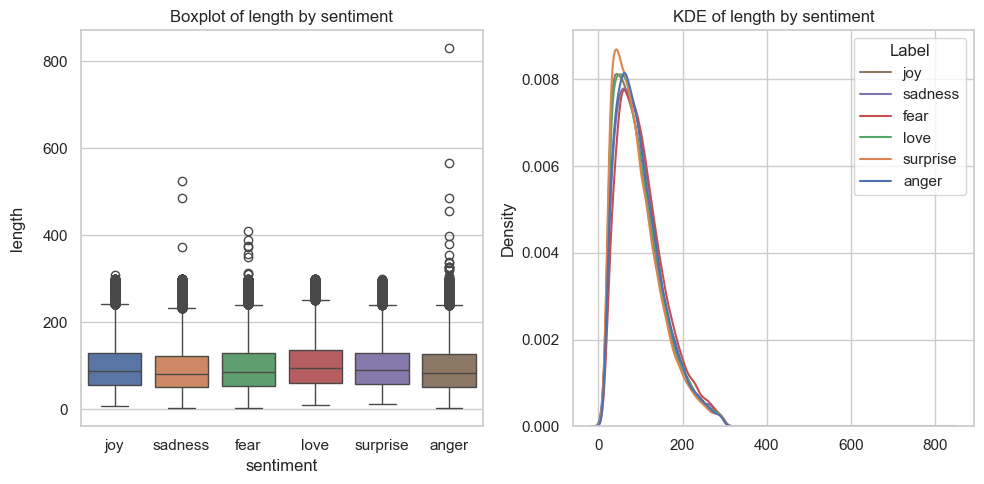

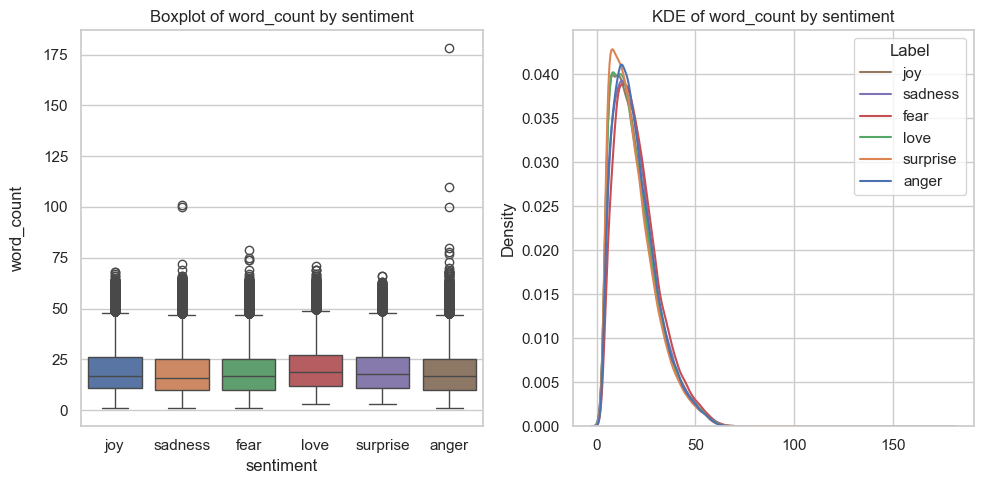

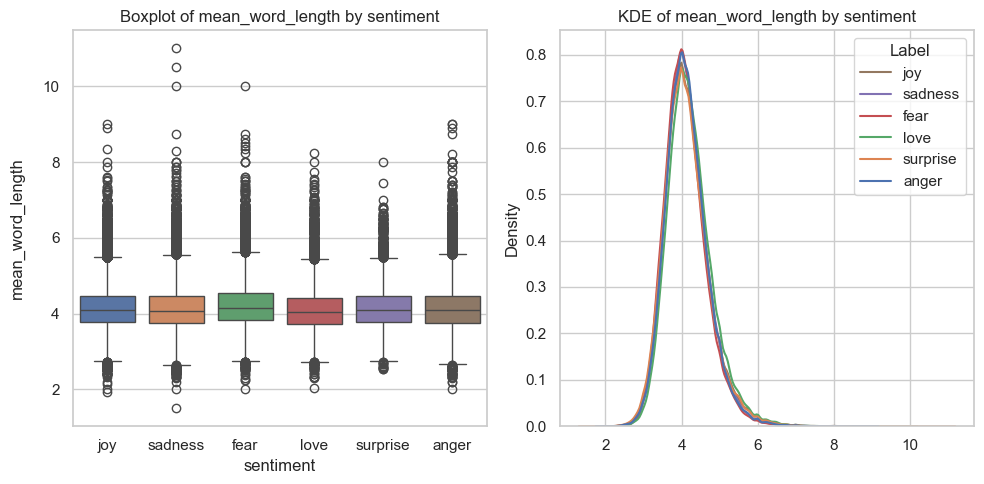

In [254]:
def visualize(col, df):
    # Set up the subplots
    plt.figure(figsize=(10, 5))

    # Boxplot for the numerical feature
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df['sentiment'], y=df[col], hue=df['sentiment'], palette= "deep")
    plt.ylabel(col, labelpad=12.5)
    plt.title(f'Boxplot of {col} by sentiment')

    # KDE plot (Kernel Density Estimation)
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=col, hue='sentiment', common_norm=False, palette= "deep")
    plt.legend(title='Label', labels=list(df['sentiment'].unique()))
    plt.xlabel('')
    plt.ylabel('Density')
    plt.title(f'KDE of {col} by sentiment')
    
    plt.tight_layout()
    plt.show()

features = df.columns.tolist()[2:]
print(features)
for feature in features:
    visualize(feature, df)

In [255]:
df = df.drop(features, axis=1)

## 2.3 Preprocess Data

### Handling missing and duplicate values in the dataset

In [258]:
df.isnull().sum()

sentence     0
sentiment    0
dtype: int64

In [259]:
df.duplicated().sum()

np.int64(0)

To be careful, we must check if there are rows having the same text but different emotions

In [261]:
df[df['sentence'].duplicated() == True]

,sentence,sentiment
115000,i just feel really helpless and heavy hearted,fear
115009,when,anger
115069,im feeling stressed about this more than i should,anger
115083,i limped along feeling helpless as my knowledg...,fear
115108,i belonged but there is a difference between f...,love
...,...,...
269328,i cryed when he seid it s only when prayer in ...,love
269337,i have not read the novel i have a feeling its...,love
269338,ive worked particularly hard with this year on...,fear
269348,i continue to feel passionate about these proj...,love


In [262]:
df[df['sentence'] == df.iloc[7654]['sentence']]

,sentence,sentiment
7654,i feel successful on this blog because of the ...,joy


In [263]:
df.iloc[7654]['sentence']

'i feel successful on this blog because of the people im following of them and we are all friend even if they dont like it'

Since a sentence can have multiple state of sentiment, we will not remove any duplicated sentence but different sentiment

### Normalize sentence by lemmatization, stemmer, removing stopwords

In [266]:
nltk.download('stopwords')
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [267]:
lemmatizer = WordNetLemmatizer()

In [268]:
stop_words = set(stopwords.words("english"))
stemmer = nltk.stem.SnowballStemmer('english')

def transform_data(sentence):
    sentence = sentence.lower()
    sentence = re.sub("^a-zA-Z0-9", ' ', sentence)
    sentence = re.sub('<.*?>', ' ', sentence)
    sentence = "".join([x for x in sentence if x not in string.punctuation])
    #sentence = stemmer.stem(sentence)
    sentence = sentence.split()
    sentence = [lemmatizer.lemmatize(x) for x in sentence if x not in stop_words]
    sentence = " ".join(sentence)
    return sentence

df['sentence'] = df['sentence'].apply(transform_data)

In [269]:
df

,sentence,sentiment
0,enjoyed feeling little cool summer shower minu...,joy
1,feel positive added,joy
2,hope question come pub quiz wont feel intelligent,joy
3,overwhelming feeling housewife child im still ...,joy
4,feel though ive become almost complacent recen...,joy
...,...,...
269350,feel like telling horny devil find site suited...,love
269351,began realize feeling agitated restless would ...,anger
269352,feel curious previous early dawn time seek tro...,surprise
269353,feel becuase tyranical nature government el sa...,anger


In [270]:
df.to_csv("Dataset/Processed dataset/processed_data.csv", index=False)

# 3. Split Dataset To Train, Validation, Test

In [296]:
def split_data(df, test_size=0.2, val_size=0.25):
    """
    Split data into train, validation, and test sets.
    test_size: proportion of the entire dataset for testing
    val_size: proportion of the training set for validation
    """
    # First split: separate test set
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df['sentiment'])
    
    # Second split: separate validation set from training set
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, random_state=42, stratify=train_val_df['sentiment'])
    
    return train_df, val_df, test_df

In [300]:
# Split data
train_df, validation_df, test_df = split_data(df)
    
# Display split sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 161613
Validation set size: 53871
Test set size: 53871


In [302]:
train_df

,sentence,sentiment
88712,feel submissive ever,sadness
22157,feel playful enough try new combination,joy
139993,find broken piece feeling nothing feeling noth...,anger
30609,feel ecstatic worry make love automatic adica ...,joy
268176,ive feeling really jealous friend rafia im ash...,anger
...,...,...
165961,feeling nervous,fear
110098,feel like punished believing austin,sadness
188196,look back little paragraph ive written feel bi...,anger
77620,feel inconvenienced trimmer blade dull,sadness


In [304]:
test_df

,sentence,sentiment
260015,im feeling cold im alone,anger
148941,feel like im th grade shy wouldnt say anything...,fear
268504,feel like navy dress dangerous,anger
67865,feel jaded chaser although,sadness
201484,feel petty vicious mean defensive angry,anger
...,...,...
203970,feeling especially tender tendency get weepy h...,love
102682,pryers feel like listening perhaps punished ba...,sadness
77514,promise never react even grievously provoked l...,sadness
114811,feel submissive spoiled,sadness


In [306]:
validation_df

,sentence,sentiment
29812,feeling lake popular weekend summer huge parki...,joy
155084,couldnt stop feeling threatened card grandmoth...,fear
104506,feel way try ignored ignored got interested es...,sadness
183002,feeling bitchy,anger
49992,know little feel special bond,joy
...,...,...
178188,think bottom line b story pierce feel need acc...,love
196994,straight man ejacalute like week sexual intere...,love
119246,feel really rude stating fact would feel rude ...,anger
248702,im feeling especially triggered grumpy note ev...,anger


## Label Encoder

In [312]:
# Transform labels
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['sentiment'])
validation_df['label'] = le.transform(validation_df['sentiment'])
test_df['label'] = le.transform(test_df['sentiment'])

In [315]:
train_df.label.value_counts()

label
2    36000
0    34341
4    33000
1    28598
3    20699
5     8975
Name: count, dtype: int64

In [318]:
label_dict = dict(zip(train_df['label'], train_df['sentiment']))
label_dict

{4: 'sadness', 2: 'joy', 0: 'anger', 3: 'love', 5: 'surprise', 1: 'fear'}

In [326]:
# Optional: Save to CSV files
train_df.to_csv("Dataset/Processed dataset/train_data.csv", index=False)
validation_df.to_csv("Dataset/Processed dataset/validation_data.csv", index=False)
test_df.to_csv("Dataset/Processed dataset/test_data.csv", index=False)

In [343]:
df[df['sentiment'] == 'surprise']

,sentence,sentiment
115004,im forever taking time lie feel weird,surprise
115030,feeling really overwhelmed,surprise
115040,really love reading bible feel presence lord j...,surprise
115051,im feeling bit amazed grateful landed amid con...,surprise
115053,sat feeling weird feeling moment later leader ...,surprise
...,...,...
269332,feel like stunned,surprise
269336,feel like muscle around eye something funny go...,surprise
269349,feel must confess even though kill say admit i...,surprise
269352,feel curious previous early dawn time seek tro...,surprise
